Loaded point cloud with 3267240 points.

Using interactive point selection.
Use Ctrl + Shift + Left-click to pick 4 points to define the polygon.
Close the viewer when you are done.
Exporting the full manually segmented point cloud with original colors...
No colors in input PCD, painting segmented points uniformly.
Exported 'segmented_plot.pcd' with original colors.
Manually segmented point cloud has 2853224 points.
Performing ground plane fitting with RANSAC on all points in the segmented plot...
Found ground plane: [a, b, c, d] = [ 0.99656844  0.02375101 -0.07929203 -1.13104593]
Ground-subtracted plot has 1561599 vegetation points.


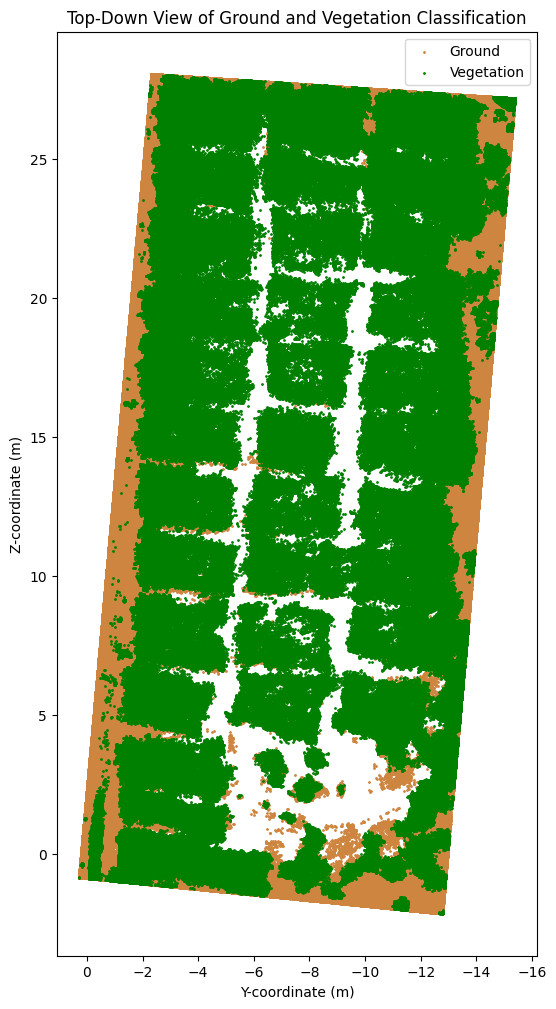

Displaying 3D vegetation (colored by height) and ground. Close to continue.

Calculating maximum heights on a high-resolution grid (0.1m x 0.1m).

Generating heatmap of high-resolution max crop heights...


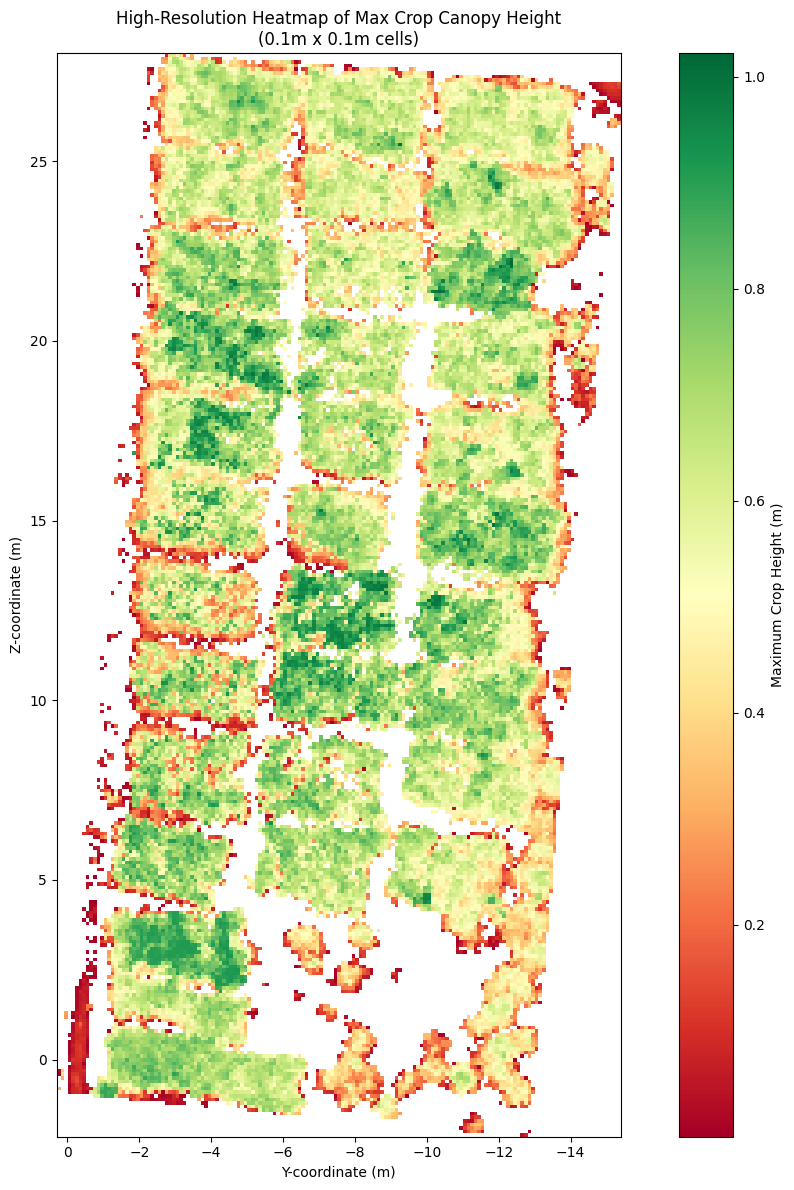

Visualizing with a 10x20 grid.


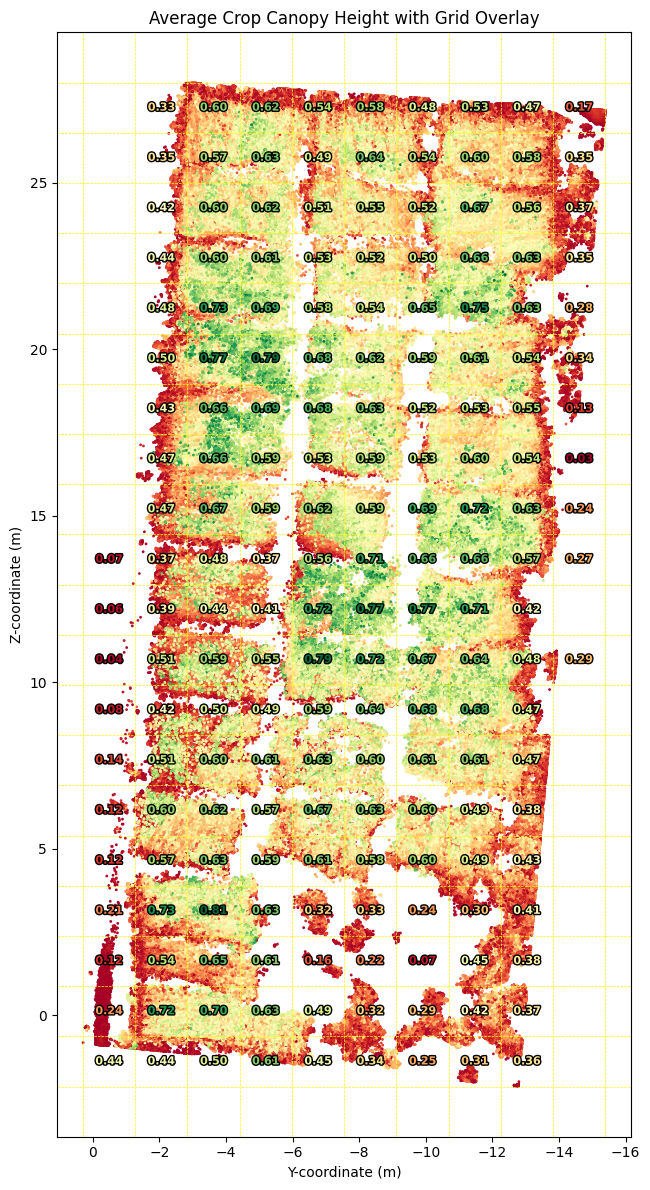


Generating heatmap of average crop heights...


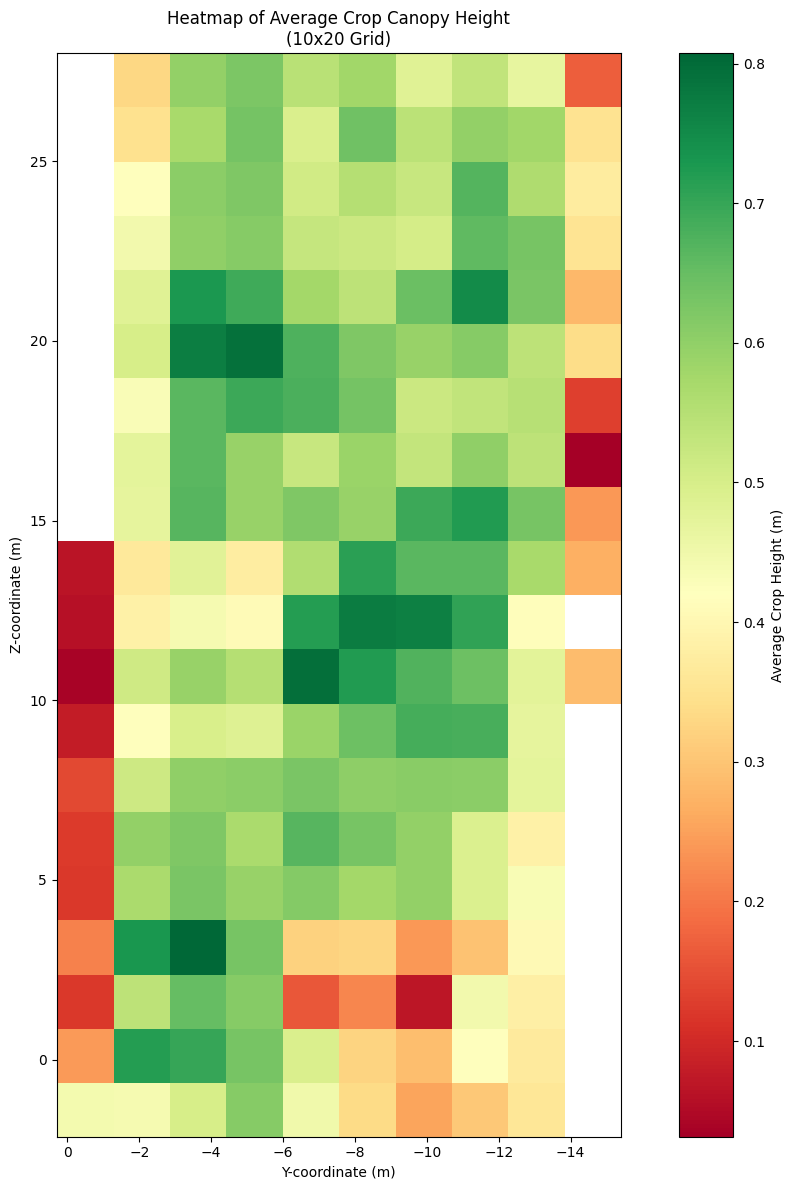


Exporting segmented ground and vegetation point clouds...
Export complete. Files saved to the 'exported_clouds' directory.
The vegetation points are colored by height, with a RdYlGn colormap.


In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path
from matplotlib.path import Path as MplPath
from scipy.ndimage import binary_dilation
import warnings
warnings.filterwarnings("ignore")

# --- USER PARAMETERS ---
INPUT_PCD = "08_28_36_47.section.pcd"
output_dir = Path("exported_clouds")
output_dir.mkdir(exist_ok=True)
NUM_GRID_SEGMENTS = 20 # The number of segments along the longest side of the plot's bounding box
HIGH_RES_CELL_SIZE = 0.1 # In meters. Used for calculating max height in small cells.
VEGETATION_HAG_THRESHOLD = 0.2 # HAG threshold for classifying vegetation points.

# VEGETATION_COLOR_THRESHOLD = 0.05 # Green color must be significantly greater than Red and Blue

# --- NEW PARAMETER: MANUALLY ENTER 4 CORNERS OR USE NONE FOR INTERACTIVE MODE ---
# Example: MANUAL_CORNERS = [[0, -5, 1], [0, 5, 1], [10, 5, 1], [10, -5, 1]]
MANUAL_CORNERS = None

def get_distance_to_plane(points, plane_model):
    """
    Calculates the perpendicular distance from points to a plane.
    """
    a, b, c, d = plane_model
    norm = np.sqrt(a**2 + b**2 + c**2)
    distances = (a * points[:, 0] + b * points[:, 1] + c * points[:, 2] + d) / norm

    if a > 0:
        distances = -distances

    return distances

def main():
    # --- 1. Load and prepare point cloud ---
    try:
        o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)
        pcd = o3d.io.read_point_cloud(INPUT_PCD)
        if pcd.is_empty():
            raise RuntimeError(f"Empty or unreadable PCD: {INPUT_PCD}")
        print(f"Loaded point cloud with {len(pcd.points)} points.")
    except Exception as e:
        print(f"Error loading point cloud: {e}")
        return

    all_points = np.asarray(pcd.points)

    # --- 2. Interactive Plot Segmentation ---
    if MANUAL_CORNERS is None:
        print("\nUsing interactive point selection.")
        print("Use Ctrl + Shift + Left-click to pick 4 points to define the polygon.")
        print("Close the viewer when you are done.")

        vis = o3d.visualization.VisualizerWithEditing()
        vis.create_window(window_name="Point Picker", width=1280, height=960)
        vis.add_geometry(pcd)
        vis.run()
        vis.destroy_window()

        picked_points_indices = vis.get_picked_points()

        if len(picked_points_indices) < 4:
            print("Not enough points selected. Please restart and select at least 4 points.")
            return

        polygon_points = all_points[picked_points_indices, :]
    else:
        print("\nUsing manually provided corner coordinates.")
        polygon_points = np.array(MANUAL_CORNERS)
        if polygon_points.shape != (4, 3):
            print("Error: MANUAL_CORNERS must be a list of 4 points (x, y, z).")
            return

    polygon_coords_yz = polygon_points[:, 1:3]

    poly_path = MplPath(polygon_coords_yz)
    all_points_yz = all_points[:, 1:3]
    inside_mask = poly_path.contains_points(all_points_yz)

    pts_segmented = all_points[inside_mask]

    # Create and save the full segmented point cloud with original colors
    print("Exporting the full manually segmented point cloud with original colors...")
    pcd_segmented_out = o3d.geometry.PointCloud()
    pcd_segmented_out.points = o3d.utility.Vector3dVector(pts_segmented)
    if pcd.has_colors():
        segmented_colors = np.asarray(pcd.colors)[inside_mask]
        pcd_segmented_out.colors = o3d.utility.Vector3dVector(segmented_colors)
    else:
        print("No colors in input PCD, painting segmented points uniformly.")
        pcd_segmented_out.paint_uniform_color([0.7, 0.7, 0.7])  # light gray

    # o3d.io.write_point_cloud(str(output_dir / "segmented_plot.pcd"), pcd_segmented_out)
    print("Exported 'segmented_plot.pcd' with original colors.")
    print(f"Manually segmented point cloud has {len(pts_segmented)} points.")

    # --- 3. Ground Subtraction on all segmented points ---
    if len(pts_segmented) == 0:
        print("No points in the segmented area. Exiting.")
        return

    print("Performing ground plane fitting with RANSAC on all points in the segmented plot...")
    pcd_segmented = o3d.geometry.PointCloud()
    pcd_segmented.points = o3d.utility.Vector3dVector(pts_segmented)
    plane_model, inliers = pcd_segmented.segment_plane(
        distance_threshold=0.03, ransac_n=3, num_iterations=2000
    )

    print(f"Found ground plane: [a, b, c, d] = {plane_model}")

    hag = get_distance_to_plane(pts_segmented, plane_model)

    valid_mask = hag >= -1.0
    pts_valid = pts_segmented[valid_mask]
    hag_valid = hag[valid_mask]

    ground_mask = hag_valid < VEGETATION_HAG_THRESHOLD
    vegetation_mask = hag_valid >= VEGETATION_HAG_THRESHOLD

    pts_ground = pts_valid[ground_mask]
    pts_vegetation = pts_valid[vegetation_mask]

    # --- Correcting HAG values for vegetation dynamically ---
    hag_vegetation = hag_valid[vegetation_mask] - VEGETATION_HAG_THRESHOLD

    # if pcd.has_colors():
    #     # Get the original colors for the points that passed the HAG filter
    #     all_colors = np.asarray(pcd.colors)
    #     valid_colors = all_colors[inside_mask][valid_mask]
    #     veg_colors = valid_colors[vegetation_mask]

    #     # Filter out non-green points. We check if the green channel is
    #     # significantly higher than both the red and blue channels.
    #     is_green = (veg_colors[:, 1] > veg_colors[:, 0] + VEGETATION_COLOR_THRESHOLD) & \
    #                (veg_colors[:, 1] > veg_colors[:, 2] + VEGETATION_COLOR_THRESHOLD)

    #     # Apply the new color filter to the vegetation points and HAG values
    #     pts_vegetation = pts_vegetation[is_green]
    #     hag_vegetation = hag_vegetation[is_green]

    #     print(f"Color filter removed {len(hag_vegetation) - len(pts_vegetation)} non-vegetation points.")
    # else:
    #     print("Warning: Original PCD does not have color data. Skipping color-based filtering.")

    print(f"Ground-subtracted plot has {len(pts_vegetation)} vegetation points.")

    # --- 4. Visualization: Top-Down Ground Classification ---
    fig_class, ax_class = plt.subplots(figsize=(12, 12))

    if len(pts_ground) > 0:
        ax_class.scatter(pts_ground[:, 1], pts_ground[:, 2], s=1, c='peru', label="Ground")

    if len(pts_vegetation) > 0:
        ax_class.scatter(pts_vegetation[:, 1], pts_vegetation[:, 2], s=1, c='green', label="Vegetation")

    ax_class.set_aspect('equal', 'box')
    ax_class.set_title("Top-Down View of Ground and Vegetation Classification")
    ax_class.set_xlabel("Y-coordinate (m)")
    ax_class.set_ylabel("Z-coordinate (m)")
    ax_class.legend()
    ax_class.set_xlim(ax_class.get_xlim()[1], ax_class.get_xlim()[0])
    plt.show()

# --- 5. Visualize points after ground subtraction (3D) ---
    if len(pts_vegetation) > 0 or len(pts_ground) > 0:
        pcd_vegetation = o3d.geometry.PointCloud()
        pcd_vegetation.points = o3d.utility.Vector3dVector(pts_vegetation)

        # Color vegetation based on height using a colormap
        if len(hag_vegetation) > 0:
            norm_hag = (hag_vegetation - np.min(hag_vegetation)) / (np.max(hag_vegetation) - np.min(hag_vegetation))
            cmap = plt.colormaps["RdYlGn"]
            colors = cmap(norm_hag)[:, :3]
            pcd_vegetation.colors = o3d.utility.Vector3dVector(colors)
        else:
            pcd_vegetation.paint_uniform_color([0.2, 0.7, 0.2]) # Default green if no vegetation

        pcd_ground = o3d.geometry.PointCloud()
        pcd_ground.points = o3d.utility.Vector3dVector(pts_ground)
        pcd_ground.paint_uniform_color([0.6, 0.4, 0.2])

        print("Displaying 3D vegetation (colored by height) and ground. Close to continue.")
        o3d.visualization.draw_geometries([pcd_vegetation, pcd_ground], window_name="3D Ground Subtraction")

    pcd_vegetation.paint_uniform_color([0.2, 0.7, 0.2]) # Default green

    # --- 6. High-Resolution Gridding for Maximum Height ---
    print(f"\nCalculating maximum heights on a high-resolution grid ({HIGH_RES_CELL_SIZE}m x {HIGH_RES_CELL_SIZE}m).")

    if len(pts_vegetation) == 0:
        print("No vegetation points found. Cannot create grid.")
        return

    y_min, y_max = np.min(pts_vegetation[:, 1]), np.max(pts_vegetation[:, 1])
    z_min, z_max = np.min(pts_vegetation[:, 2]), np.max(pts_vegetation[:, 2])

    high_res_y = int(np.ceil((y_max - y_min) / HIGH_RES_CELL_SIZE))
    high_res_z = int(np.ceil((z_max - z_min) / HIGH_RES_CELL_SIZE))

    max_height_grid = np.full((high_res_y, high_res_z), np.nan)

    yi = np.floor((pts_vegetation[:, 1] - y_min) / HIGH_RES_CELL_SIZE).astype(int)
    zi = np.floor((pts_vegetation[:, 2] - z_min) / HIGH_RES_CELL_SIZE).astype(int)

    grid_bins = {}
    for i in range(len(pts_vegetation)):
        y_idx, z_idx = yi[i], zi[i]
        if 0 <= y_idx < high_res_y and 0 <= z_idx < high_res_z:
            key = (y_idx, z_idx)
            if key in grid_bins:
                grid_bins[key] = max(grid_bins[key], hag_vegetation[i])
            else:
                grid_bins[key] = hag_vegetation[i]

    for (y_idx, z_idx), h in grid_bins.items():
        max_height_grid[y_idx, z_idx] = h

    # --- 6.5. High-Resolution Heatmap Visualization ---
    print("\nGenerating heatmap of high-resolution max crop heights...")

    fig_high_res_heatmap, ax_high_res_heatmap = plt.subplots(figsize=(12, 12))

    # Use imshow to create the heatmap from the max_height_grid
    # We transpose the array to correctly align the Y-Z axes with the scatter plot
    heatmap = ax_high_res_heatmap.imshow(
        max_height_grid.T,
        cmap='RdYlGn',
        origin='lower',
        extent=(y_min, y_max, z_min, z_max)
    )

    cbar = plt.colorbar(heatmap, ax=ax_high_res_heatmap, label='Maximum Crop Height (m)')

    ax_high_res_heatmap.set_aspect('equal', 'box')
    ax_high_res_heatmap.set_title(f"High-Resolution Heatmap of Max Crop Canopy Height\n({HIGH_RES_CELL_SIZE}m x {HIGH_RES_CELL_SIZE}m cells)")
    ax_high_res_heatmap.set_xlabel("Y-coordinate (m)")
    ax_high_res_heatmap.set_ylabel("Z-coordinate (m)")

    # Invert the y-axis to match the top-down point cloud view
    ax_high_res_heatmap.set_xlim(ax_high_res_heatmap.get_xlim()[1], ax_high_res_heatmap.get_xlim()[0])

    plt.tight_layout()
    plt.show()

    # --- 7. Final Visualization Grid (Averaging the max heights) ---
    y_range = y_max - y_min
    z_range = z_max - z_min

    if y_range > z_range:
        grid_y = NUM_GRID_SEGMENTS
        grid_z = int(NUM_GRID_SEGMENTS * (z_range / y_range))
    else:
        grid_z = NUM_GRID_SEGMENTS
        grid_y = int(NUM_GRID_SEGMENTS * (y_range / z_range))

    if grid_y == 0: grid_y = 1
    if grid_z == 0: grid_z = 1

    print(f"Visualizing with a {grid_y}x{grid_z} grid.")

    final_height_grid = np.full((grid_y, grid_z), np.nan)

    for y_idx in range(grid_y):
        for z_idx in range(grid_z):
            y_start = y_min + y_idx * (y_range / grid_y)
            y_end = y_start + (y_range / grid_y)
            z_start = z_min + z_idx * (z_range / grid_z)
            z_end = z_start + (z_range / grid_z)

            high_res_y_start = int(np.floor((y_start - y_min) / HIGH_RES_CELL_SIZE))
            high_res_y_end = int(np.ceil((y_end - y_min) / HIGH_RES_CELL_SIZE))
            high_res_z_start = int(np.floor((z_start - z_min) / HIGH_RES_CELL_SIZE))
            high_res_z_end = int(np.ceil((z_end - z_min) / HIGH_RES_CELL_SIZE))

            sub_grid = max_height_grid[high_res_y_start:high_res_y_end, high_res_z_start:high_res_z_end]

            valid_heights = sub_grid[~np.isnan(sub_grid)]
            if valid_heights.size > 0:
                final_height_grid[y_idx, z_idx] = np.mean(valid_heights)

# --- 8. Final visualization with grid overlay ---
    fig, ax = plt.subplots(figsize=(12, 12))

    # We capture the scatter plot to use it for the colorbar
    scatter_plot = ax.scatter(pts_vegetation[:, 1], pts_vegetation[:, 2], s=1, c=hag_vegetation, cmap='RdYlGn', label="Vegetation Points")

    # Add the colorbar based on the scatter plot
    # cbar = fig.colorbar(scatter_plot, ax=ax)
    # cbar.set_label('Height Above Ground (m)')

    for y_idx in range(grid_y + 1):
        ax.axvline(y_min + y_idx * (y_range / grid_y), color='yellow', linestyle='--', linewidth=0.5)
    for z_idx in range(grid_z + 1):
        ax.axhline(z_min + z_idx * (z_range / grid_z), color='yellow', linestyle='--', linewidth=0.5)

    ax.set_aspect('equal', 'box')
    ax.set_title("Average Crop Canopy Height with Grid Overlay")
    ax.set_xlabel("Y-coordinate (m)")
    ax.set_ylabel("Z-coordinate (m)")
    ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])

    # Get the colormap and normalize heights for text color
    cmap = plt.colormaps['RdYlGn']
    valid_heights_flat = final_height_grid[~np.isnan(final_height_grid)]

    if valid_heights_flat.size > 1:
        h_min, h_max = np.min(valid_heights_flat), np.max(valid_heights_flat)
        norm_factor = h_max - h_min
    elif valid_heights_flat.size == 1:
        h_min = h_max = valid_heights_flat[0]
        norm_factor = 1
    else:
        norm_factor = 1
        h_min = 0

    for y_idx in range(grid_y):
        for z_idx in range(grid_z):
            avg_h = final_height_grid[y_idx, z_idx]
            if not np.isnan(avg_h):
                if norm_factor > 0:
                    normalized_h = (avg_h - h_min) / norm_factor
                    text_color = cmap(normalized_h)
                else:
                    text_color = cmap(0.5)

                ax.text(y_min + (y_idx + 0.5) * (y_range / grid_y),
                        z_min + (z_idx + 0.5) * (z_range / grid_z),
                        f"{avg_h:.2f}",
                        ha='center', va='center', color=text_color, fontsize=8,
                        fontweight='bold',
                        path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    plt.tight_layout()
    plt.show()

# --- 9. Heatmap Visualization ---
    print("\nGenerating heatmap of average crop heights...")

    fig_heatmap, ax_heatmap = plt.subplots(figsize=(12, 12))

    # Use imshow on the final_height_grid to create the heatmap
    heatmap = ax_heatmap.imshow(
        final_height_grid.T, # Transpose for correct orientation
        cmap='RdYlGn',
        origin='lower',
        extent=(y_min, y_max, z_min, z_max)
    )

    cbar = plt.colorbar(heatmap, ax=ax_heatmap, label='Average Crop Height (m)')

    ax_heatmap.set_aspect('equal', 'box')
    ax_heatmap.set_title(f"Heatmap of Average Crop Canopy Height\n({grid_y}x{grid_z} Grid)")
    ax_heatmap.set_xlabel("Y-coordinate (m)")
    ax_heatmap.set_ylabel("Z-coordinate (m)")

    # Invert the y-axis to match the point cloud view
    ax_heatmap.set_xlim(ax_heatmap.get_xlim()[1], ax_heatmap.get_xlim()[0])

    plt.tight_layout()
    plt.show()

    # --- 10. Export Point Clouds for CloudCompare with Height-Based Colors ---
    print("\nExporting segmented ground and vegetation point clouds...")

    pcd_ground_out = o3d.geometry.PointCloud()
    pcd_ground_out.points = o3d.utility.Vector3dVector(pts_ground)
    pcd_ground_out.paint_uniform_color([0.8, 0.8, 0.8])

    unique_cells = np.unique(np.vstack((yi, zi)).T, axis=0)
    top_points_indices = []
    for y_idx, z_idx in unique_cells:
        cell_mask = (yi == y_idx) & (zi == z_idx)
        if np.any(cell_mask):
            max_height_idx = np.argmax(hag_vegetation[cell_mask])
            global_idx = np.where(cell_mask)[0][max_height_idx]
            top_points_indices.append(global_idx)

    top_points_indices = np.array(top_points_indices)
    pts_top_vegetation = pts_vegetation[top_points_indices]
    hag_top_vegetation = hag_vegetation[top_points_indices]

    pcd_top_vegetation_out = o3d.geometry.PointCloud()
    pcd_top_vegetation_out.points = o3d.utility.Vector3dVector(pts_top_vegetation)

    if len(hag_top_vegetation) > 0:
        norm_hag = (hag_top_vegetation - np.min(hag_top_vegetation)) / (np.max(hag_top_vegetation) - np.min(hag_top_vegetation))
        cmap = plt.cm.get_cmap("RdYlGn")
        colors = cmap(norm_hag)[:, :3]
        pcd_top_vegetation_out.colors = o3d.utility.Vector3dVector(colors)
    else:
        pcd_top_vegetation_out.paint_uniform_color([0.2, 0.7, 0.2])


    # o3d.io.write_point_cloud(str(output_dir / "ground_points.pcd"), pcd_ground_out)
    # o3d.io.write_point_cloud(str(output_dir / "vegetation_points.pcd"), pcd_vegetation) # Changed from pcd_vegetation_out to pcd_vegetation to export all vegetation points
    # o3d.io.write_point_cloud(str(output_dir / "top_vegetation_points.pcd"), pcd_top_vegetation_out)

    print("Export complete. Files saved to the 'exported_clouds' directory.")
    print("The vegetation points are colored by height, with a RdYlGn colormap.")

if __name__ == "__main__":
    main()